In [1]:
import pickle

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import segyio

from scipy.optimize import least_squares

from scipy.sparse.linalg import lsqr
from pylops.basicoperators import *
from pylops.optimization.leastsquares import *

from refrtomo.gaussnewton import gauss_newton
from refrtomo.invert import *
from refrtomo.survey import *

from refrtomo.segyshot import SegyShot, rotate
from refrtomo.utils import *
from refrtomo.picking import *

# # Save the lists to a file
# with open('avasurvey_matched.pkl', 'wb') as file:
#     pickle.dump({'avasurvey_matched': avasurvey_matched, 'initsurvey_matched': initsurvey_matched}, file)

# Volve Dataset 

This section include reading the data, First break picking, Ray tracing, and smoothed velocty model creation

In [2]:
# Import the 2D seismic data and 3D Velocity model
inputfile = '../data/ST10010_1150780_40203_2dline1.sgy'
velfile = '../data/ST10010ZC11-MIG-VEL.MIG_VEL.VELOCITY.3D.JS-017527.segy'

# Open the 2D seismic data
f = segyio.open(inputfile, ignore_geometry=True)

In [3]:
# Number of traces
nTraces =  f.bin[segyio.BinField.Traces]
print(f"Number of traces = {nTraces}")

# Create the SegyShot object
sg = SegyShot(inputfile, components=['P', 'VZ', 'VX', 'VY'])
# Scan the shot gathers and get attributes
sg.interpret()

# Get time axis
t = sg.t
dt = t[1] - t[0]
print(f"dt = {dt} ms")

# Store attributes
nSrc = sg.nsrc  # number of sources
nRec = sg.nrec  # number of receivers
nT = sg.nt      # number of time samples

print(f"Number of sources = {nSrc}")
print(f"Number of receivers = {nRec}")
print(f"Number of time samples = {nT}")

Number of traces = 960
dt = 0.002 ms
Number of sources = 30
Number of receivers = 240
Number of time samples = 2000


In [4]:
# Open the 3D velocity model
fv = segyio.open(velfile)

# Depth axes
z = fv.samples[0:186]
il, xl = fv.ilines, fv.xlines

# Create the 3D Array with the velocity model
vmod = segyio.cube(velfile)
print(f"3D velocity model shape {vmod.shape}")

# Select the closest inline to geometry of the 2D seismic data
inline = 10
vmod2d = vmod[inline, 50:190, 0:186] # Short it laterally and vertically

# Initial velocity (smooth migration velocity)
nsmooth = 5
vel_init = vmod2d.copy()
for _ in range(4):
    vel_init = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, vel_init, axis=1)
    vel_init = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, vel_init, axis=0)

# Extract the velocity local coordinates
with segyio.open(velfile, "r") as vel:
    scvel = vel.header[0][segyio.TraceField.SourceGroupScalar]
    if scvel < 0:
        scvel = 1. / abs(scvel)
    xvel = scvel * vel.attributes(segyio.TraceField.CDP_X)[xl.size*(inline):xl.size*(inline+1)]
    yvel = scvel * vel.attributes(segyio.TraceField.CDP_Y)[xl.size*(inline):xl.size*(inline+1)]
    rot, ox, oy = segyio.tools.rotation(vel, line='fast')
    ox, oy = scvel * ox, scvel * oy
    rot = (rot - np.pi / 2)

    xvel_local, yvel_local = rotate(xvel, yvel, ox, oy, rot)

# Short laterally the x, y coordiantes
x = xvel_local[50:190]   # Velocity model is truncated 
y = yvel_local[50:190]

3D velocity model shape (109, 241, 226)


In [5]:
# Convert the geometry to local, rectangular coordinates
sg.rotategeometry(velfile=velfile, plotflag=0)  # inline 10 is the inline of the 2D li

Local regular axis:
 ox=0.000000, dx=49.793406 nx=241
 oy=-0.000000, dy=49.540976 ny=109


(49.79340614637832, 241, 49.54097588003794, 109)

In [6]:
# Import the traveltimes of the first arrivals from npz file
ttfile = '../data/FirstArrivalVolve.npz'
tfirsts = np.load(ttfile)['tfirsts']

In [7]:
# Get sources and receivers x and z coordiantes
srcs = np.vstack((sg.srcx_local, sg.srcz))
recs = np.vstack((sg.recx_local, sg.recz))

survey = survey_geom(srcs, recs, minoffset=100)
avasurvey = survey_geom_observed(srcs, recs, tobs=tfirsts, minoffset=100)

# Lenght and steps of rays
lmax = 20000
nl = 20000

# Substitute x for ints int version
xint = np.round(x).astype(int)

# Choose angles to shoot rays, considering the size of the vel. model
thetas = np.hstack([np.arange(-70, -0.2, 0.2), np.arange(0.2, 70, 0.2)])

In [8]:
# Find rays that arrive to the receivers
initsurvey = survey_raytrace(survey, vel_init.T, x, z,\
     lmax, nl, thetas, dzout=1., ray_rec_mindistance=5., debug=True, tolerance_z=5.)

# Match surveys
avasurvey_matched, initsurvey_matched = match_surveys(avasurvey, initsurvey)

survey_raytrace: 6960 Source-receiver pairs in survey, 342 Source-receiver paired with ray...


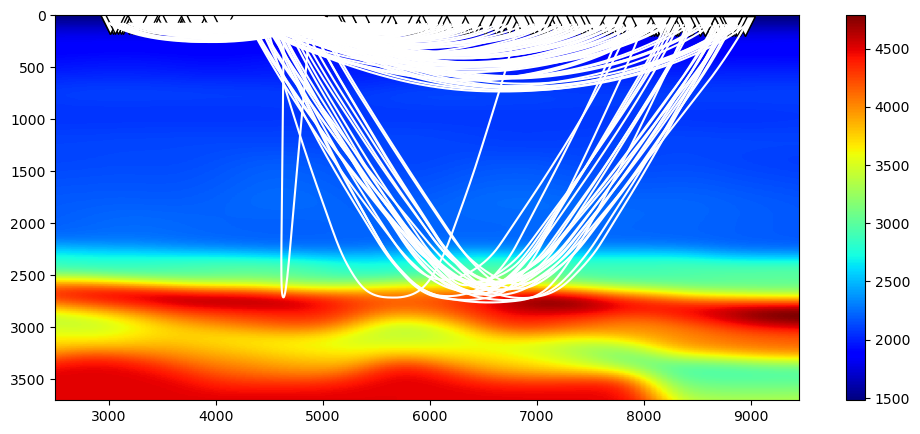

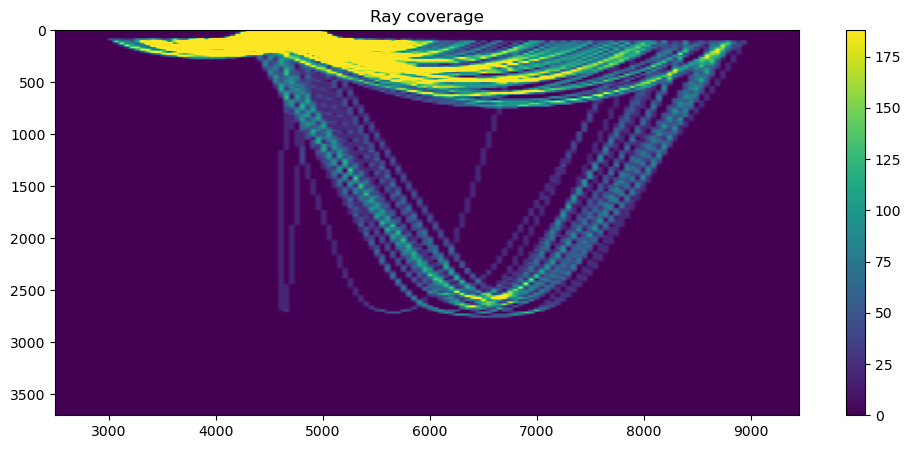

In [11]:
# Create tomographic matrix
dx = int(np.mean(np.abs(np.diff(x)))); dz = z[1] - z[0]
ox = x[0]; oz = z[0]
nx = len(x); nz = len(z)

# Tomographic matrix and traveltimes
Rinit = tomographic_matrix(initsurvey_matched, dx, dz, ox, oz, nx, nz, x, z, \
    plotflag=True, vel=vel_init, figsize=(12, 5))

# R matrix condition

In [ ]:
# Compute the SVD of the tomographic matrix 
U, s, Vh = np.linalg.svd(Rinit.toarray())

In [15]:
condition_number = np.max(s) / np.min(s)  # S[0] is the largest, S[-1] is the smallest singular value
rank = np.linalg.matrix_rank(Rinit.todense())
print("shape of R", Rinit.shape)
print("Condition number of R:", condition_number)
print("rank  of R:", rank)

shape of R (342, 26040)
Condition number of R: 486.6912043596477
rank  of R: 342


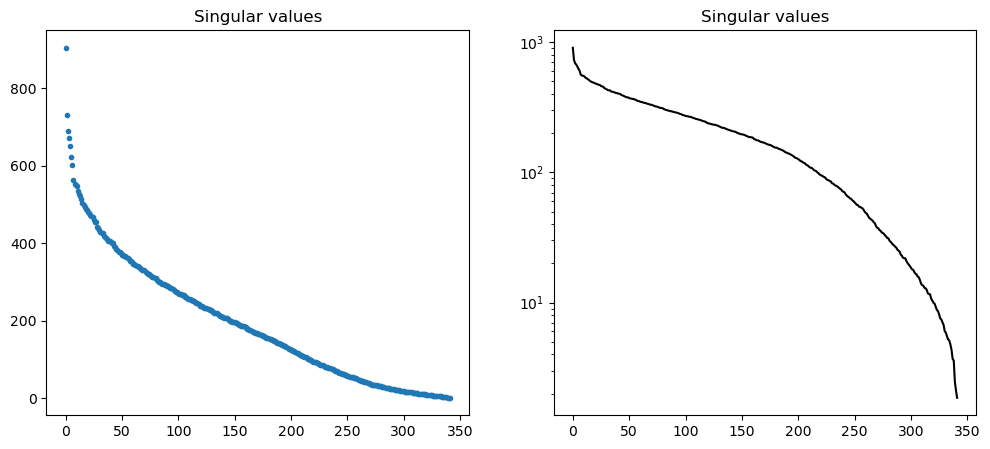

In [18]:
# Plot singular values
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(s, '.')
ax[0].set_title('Singular values')
ax[1].semilogy(s, 'k')
ax[1].set_title('Singular values')
plt.show()

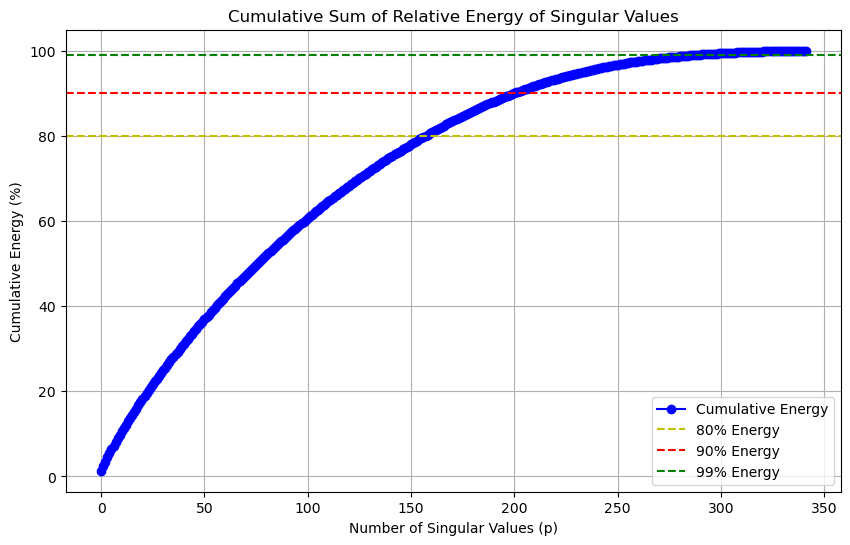

Rank truncation p for 90% energy: 158
Rank truncation p for 90% energy: 201
Rank truncation p for 99% energy: 289


In [16]:
# Calculate the relative energy of each singular value
total_energy = np.sum(s)
relative_energy = (s / total_energy) * 100

# Compute the cumulative sum of relative energies
cumulative_energy = np.cumsum(relative_energy)

# Plot the cumulative energy
plt.figure(figsize=(10, 6))
plt.plot(cumulative_energy, marker='o', linestyle='-', color='b', label="Cumulative Energy")
plt.axhline(y=80, color='y', linestyle='--', label="80% Energy")
plt.axhline(y=90, color='r', linestyle='--', label="90% Energy")
plt.axhline(y=99, color='g', linestyle='--', label="99% Energy")
plt.xlabel("Number of Singular Values (p)")
plt.ylabel("Cumulative Energy (%)")
plt.title("Cumulative Sum of Relative Energy of Singular Values")
plt.legend()
plt.grid(True)
plt.show()

# Determine optimal rank truncation p
p_80 = np.argmax(cumulative_energy >= 80) + 1  # First p where cumulative energy reaches 90%
p_90 = np.argmax(cumulative_energy >= 90) + 1  # First p where cumulative energy reaches 90%
p_99 = np.argmax(cumulative_energy >= 99) + 1  # First p where cumulative energy reaches 99%

print(f"Rank truncation p for 90% energy: {p_80}")
print(f"Rank truncation p for 90% energy: {p_90}")
print(f"Rank truncation p for 99% energy: {p_99}")

### Tikhonov regularization incorporating the Laplacian operator as the smoothing term, implemented using the Naive Gauss-Newton Method.


survey_raytrace: 6960 Source-receiver pairs in survey, 342 Source-receiver paired with ray...
match_surveys: 6960 Rays in survey1, 342 Rays in survey2, 342 Matched rays...
tomographic_matrix: 342 rows, 26040 columns
Iteration 1/5, Misfit 0.0141
survey_raytrace: 6960 Source-receiver pairs in survey, 372 Source-receiver paired with ray...
match_surveys: 6960 Rays in survey1, 372 Rays in survey2, 372 Matched rays...
tomographic_matrix: 372 rows, 26040 columns
Iteration 2/5, Misfit 0.0114
survey_raytrace: 6960 Source-receiver pairs in survey, 361 Source-receiver paired with ray...
match_surveys: 6960 Rays in survey1, 361 Rays in survey2, 361 Matched rays...
tomographic_matrix: 361 rows, 26040 columns
Iteration 3/5, Misfit 0.0074
survey_raytrace: 6960 Source-receiver pairs in survey, 348 Source-receiver paired with ray...
match_surveys: 6960 Rays in survey1, 348 Rays in survey2, 348 Matched rays...
tomographic_matrix: 348 rows, 26040 columns
Iteration 4/5, Misfit 0.0137
survey_raytrace: 696

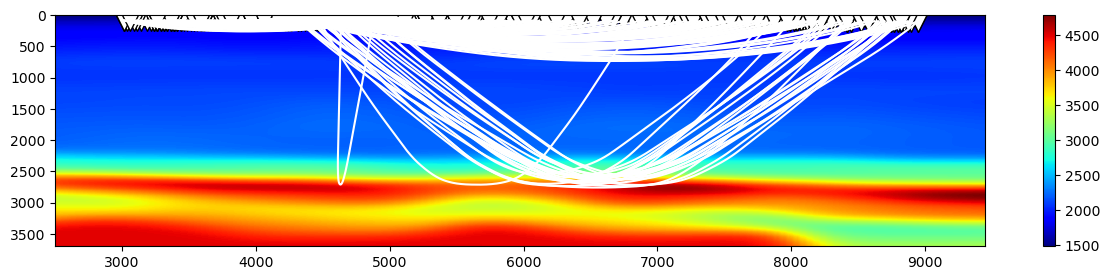

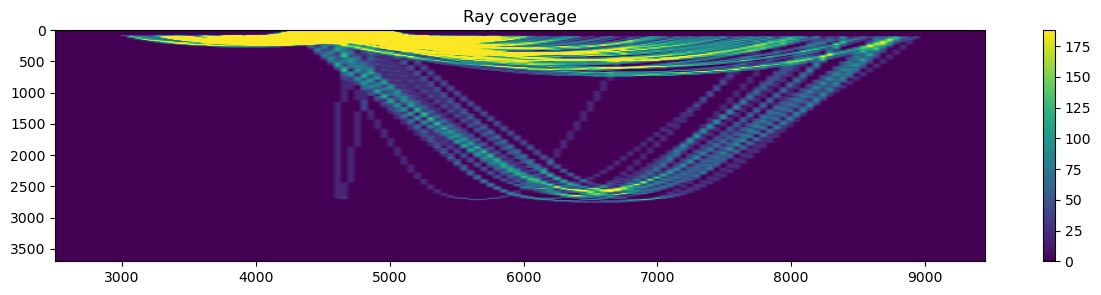

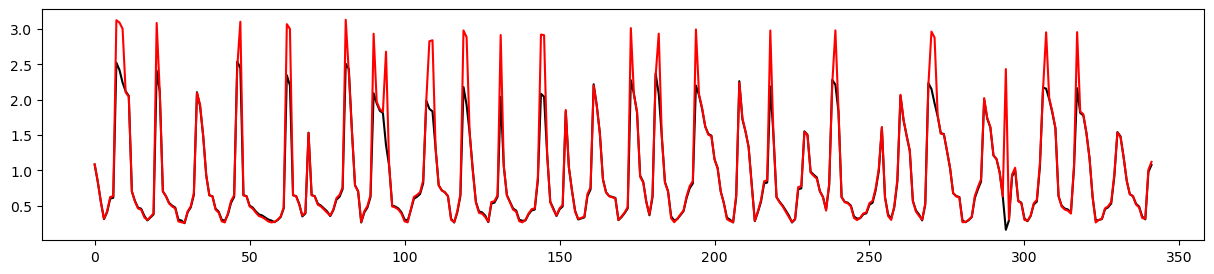

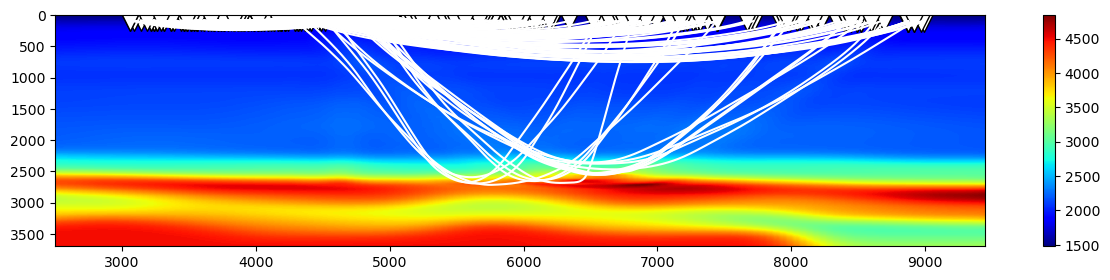

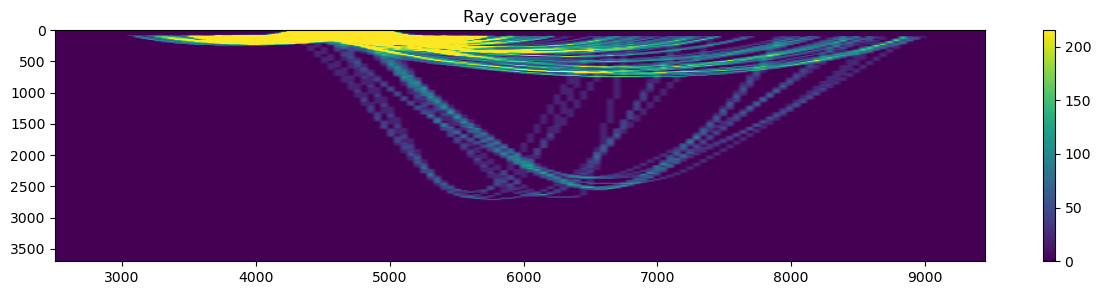

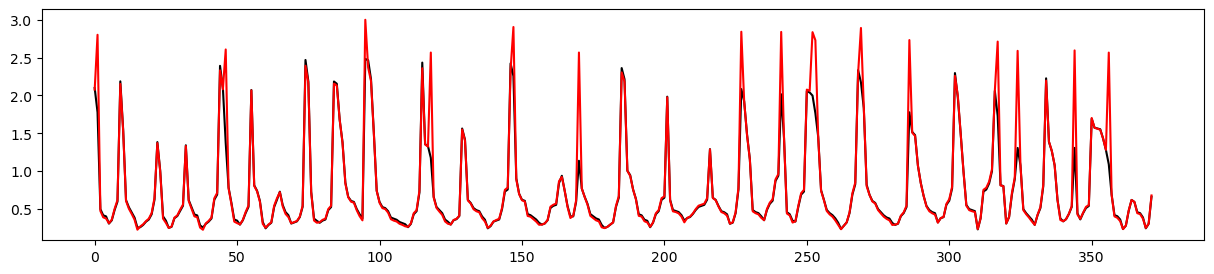

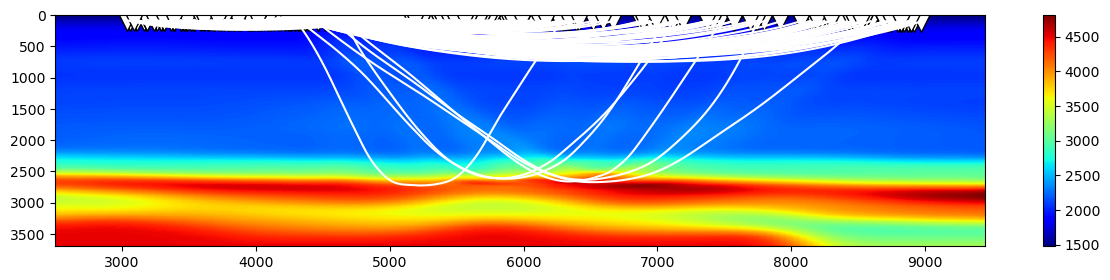

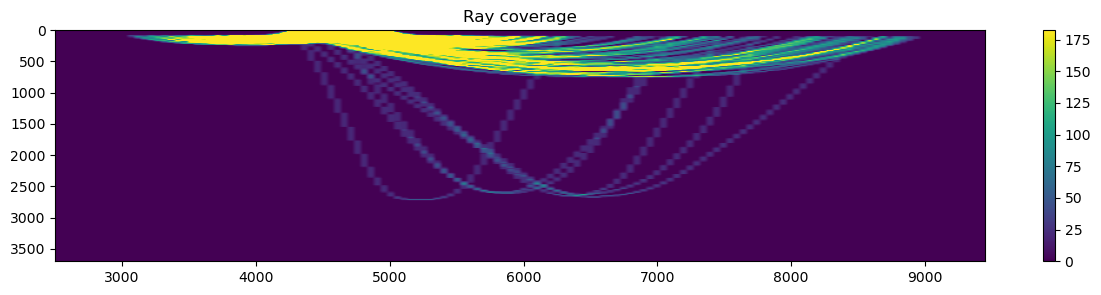

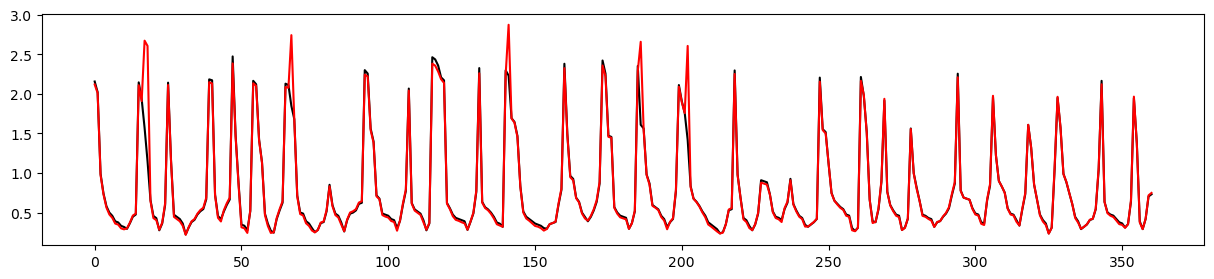

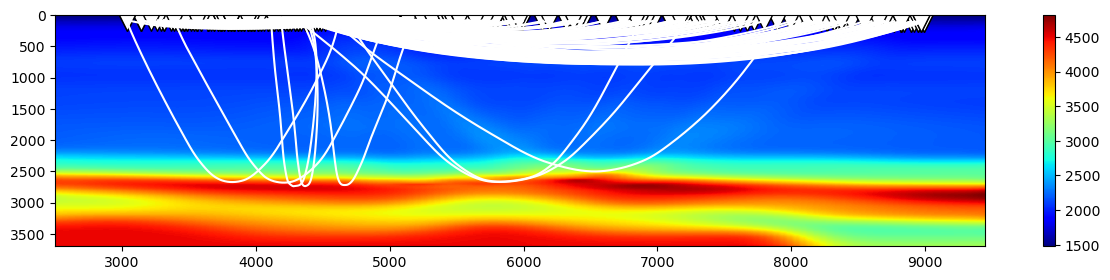

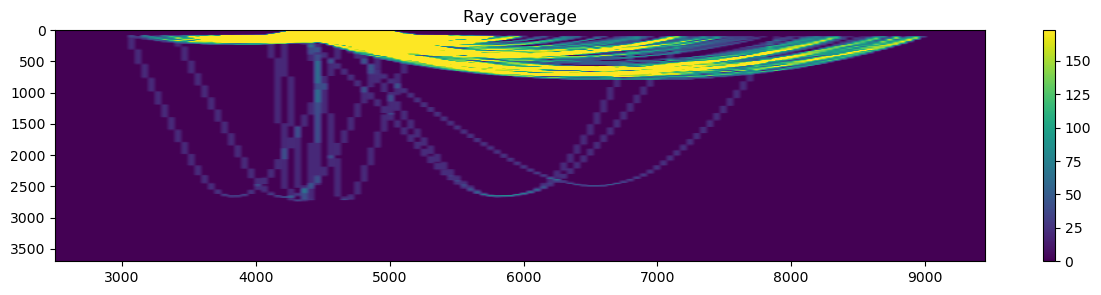

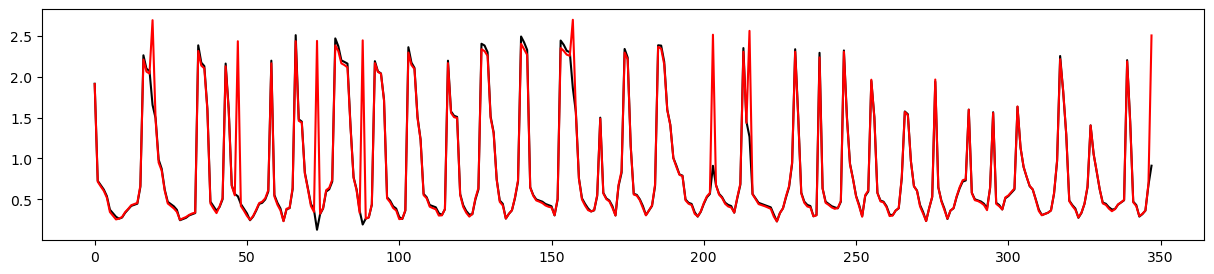

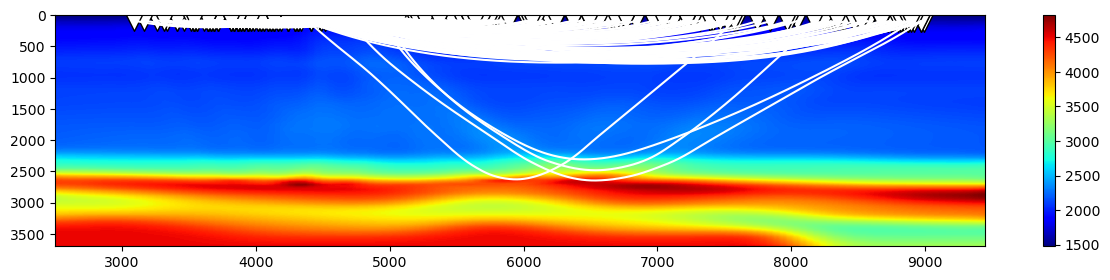

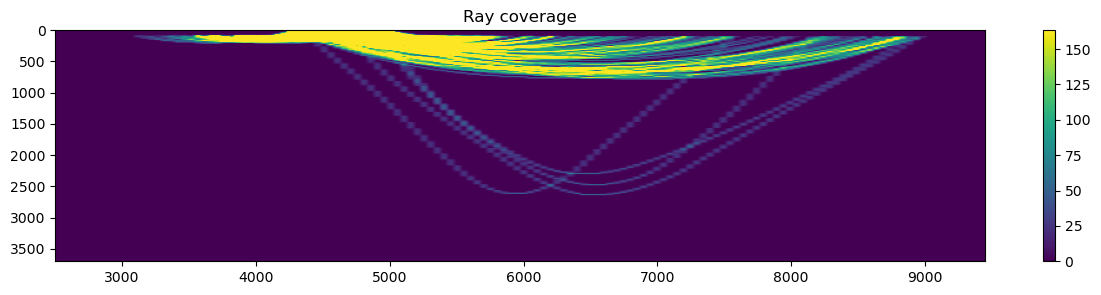

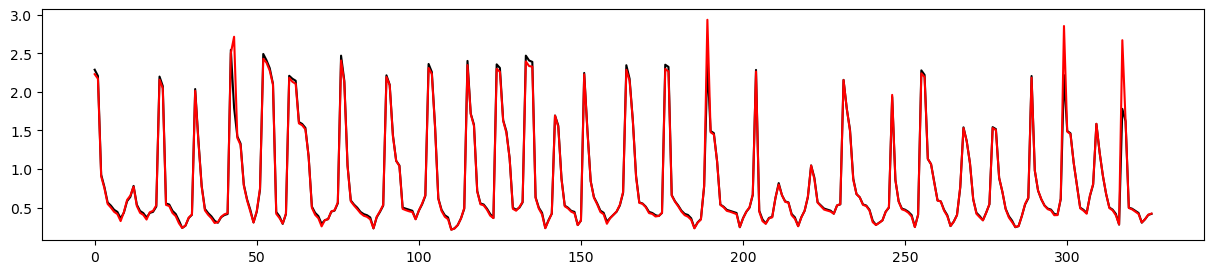

In [82]:
# second version, updating dslow with full dtobs at each step
ngniter = 5

Dop = Laplacian((nx, nz), weights=(45, 15))
vel_inv = vel_init.copy()
slown_inv = 1. / vel_inv.ravel()
misfit = []
for iiter in range(ngniter):
    # Raytrace in initial model
    invsurvey = survey_raytrace(survey, vel_inv.T, x, z, lmax, nl, thetas, dzout=5., ray_rec_mindistance=5., tolerance_z=5., debug=True)

    # Match surveys
    avasurvey_matched, invsurvey_matched = match_surveys(avasurvey, invsurvey, debug=True)

    # Tomographic matrix and traveltimes
    Rinv = tomographic_matrix(invsurvey_matched, dx, dz, ox, oz, nx, nz, x, z, debug=True, plotflag=True, vel=vel_inv)
    tobs = extract_tobs(avasurvey_matched)
    tinv = Rinv @ slown_inv
    
    # Residual data
    dtobs = tobs - tinv
    misfit.append(np.linalg.norm(tobs - tinv) / len(tobs))
    print(f'Iteration {iiter+1}/{ngniter}, Misfit {misfit[-1]:.4f}')
    plt.figure(figsize=(15, 3))
    plt.plot(tobs, 'k')
    plt.plot(tinv, 'r')
    
    # Invert slowness update (just few iterations to avoid overfitting at each step)
    dslown_inv = regularized_inversion(MatrixMult(Rinv), 
                                       dtobs, [Dop,], 
                                       epsRs=[8e1,], dataregs=[-Dop * slown_inv.ravel(), ], 
                                       **dict(iter_lim=10, damp=1.6e3))[0]
    slown_inv += dslown_inv
    vel_inv = 1. / (slown_inv.reshape(nx, nz) + 1e-10)

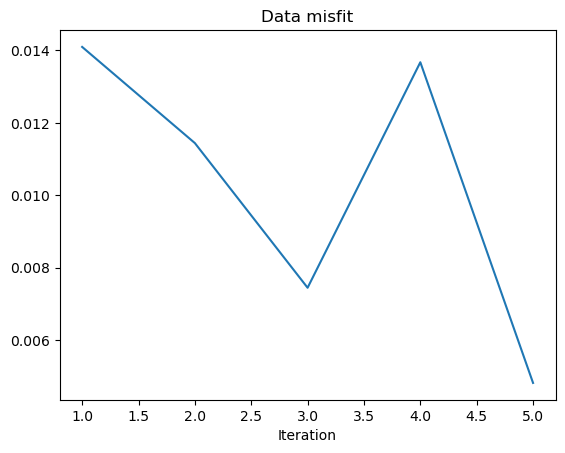

In [88]:
# Plot the misfit
x_iter = np.arange(1, ngniter+1)

plt.figure()
plt.plot(x_iter, misfit)
plt.title('Data misfit')
plt.xlabel('Iteration')
plt.show()

Compare the inverted velocity with the initial velocity model to spot the areas where it changes.

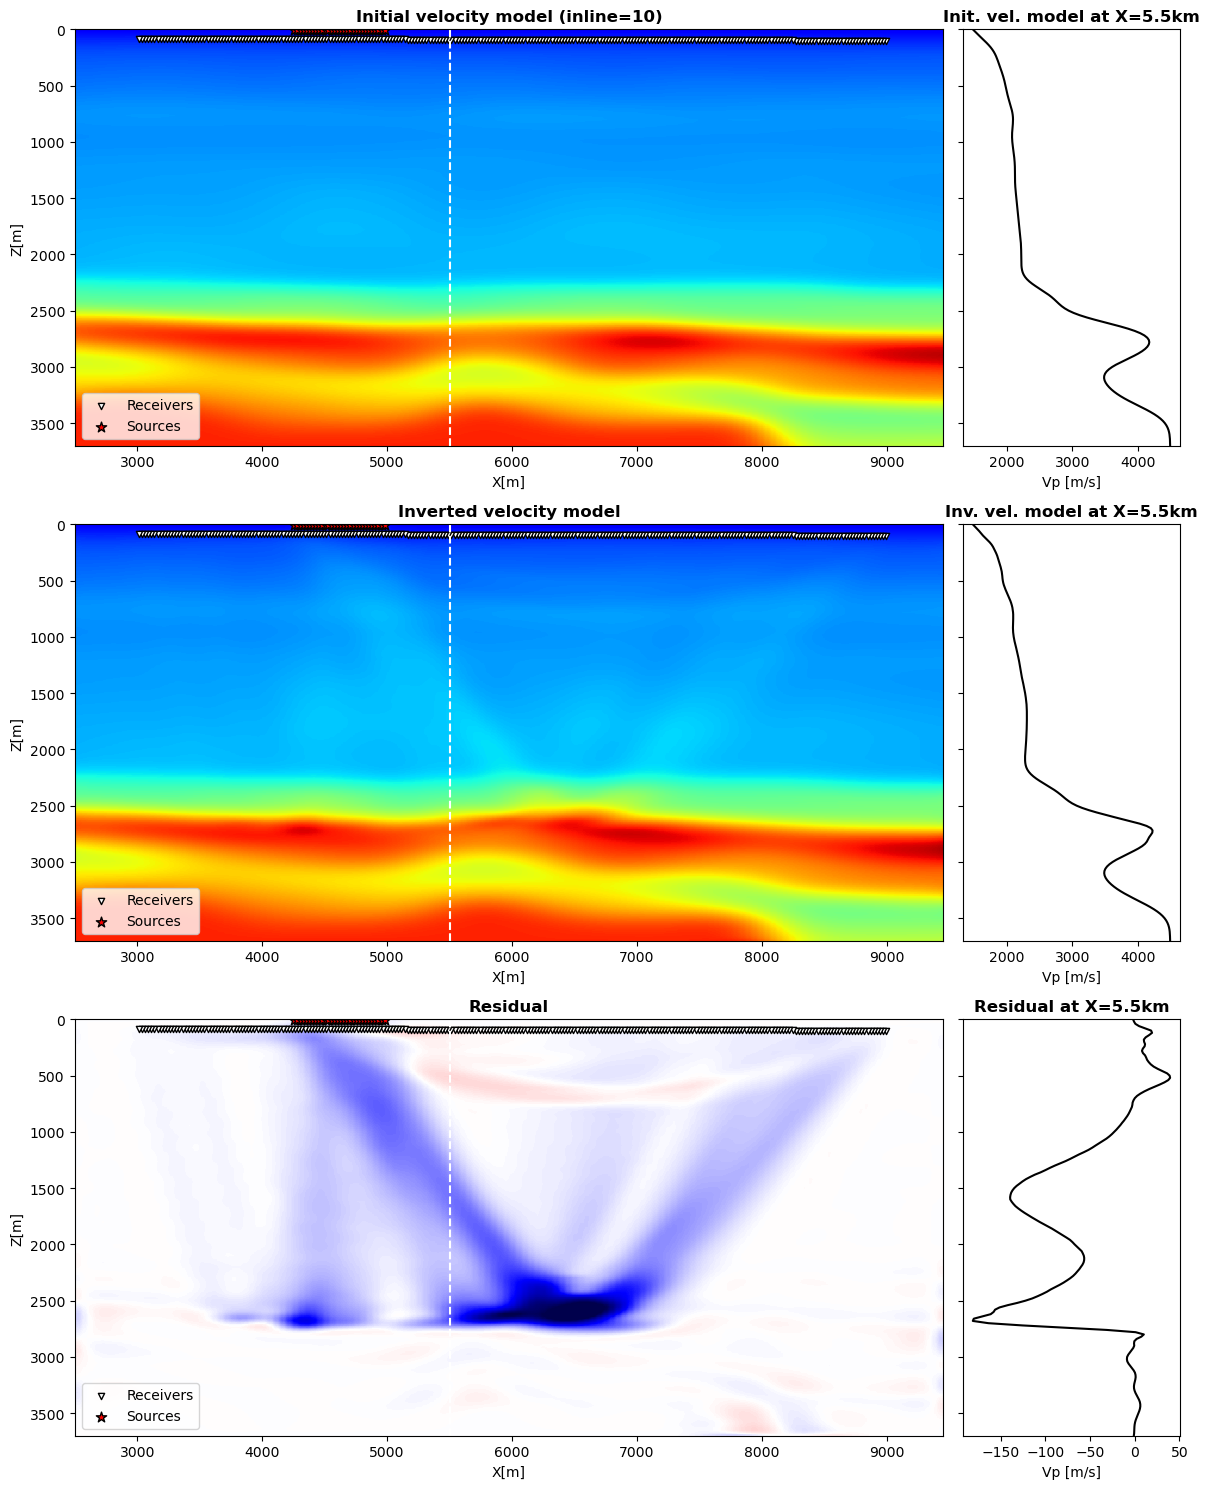

In [ ]:
# Display velocity model
fig, axs = plt.subplots(3, 2, figsize=(12, 15), sharey=True, gridspec_kw={'width_ratios': [4, 1]})

vmin=1000; vmax=5000

# Plot initial velocity model
axs[0, 0].imshow(vel_init.T, extent=(x[0], x[-1], z[-1], z[0]), cmap='jet', vmin=vmin, vmax=vmax)
# Show receivers and sources
axs[0, 0].scatter(sg.recx_local, sg.recz, marker='v', s=20, c='w', edgecolors='k', label='Receivers')
axs[0, 0].scatter(sg.srcx_local, sg.srcz, marker='*', s=60, c='r', edgecolors='k', label='Sources')

# Do a vertical profile
prf = 60
axs[0, 0].axvline(x[prf], color='w', linestyle='--')

axs[0, 0].set_title(f'Initial velocity model (inline={inline})', fontweight='bold')
axs[0, 0].set_xlabel('X[m]')
axs[0, 0].set_ylabel('Z[m]')
axs[0, 0].axis('tight')
axs[0, 0].legend()

# Plot velocity profile at XL=40
axs[0, 1].plot(vel_init[prf], z, 'k')
axs[0, 1].set_title('Init. vel. model at X=5.5km', fontweight='bold')
axs[0, 1].set_xlabel('Vp [m/s]')

# Plot inverted velocity model
axs[1, 0].imshow(vel_inv.T, extent=(x[0], x[-1], z[-1], z[0]), cmap='jet', vmin=vmin, vmax=vmax)
# Show receivers and sources
axs[1, 0].scatter(sg.recx_local, sg.recz, marker='v', s=20, c='w', edgecolors='k', label='Receivers')
axs[1, 0].scatter(sg.srcx_local, sg.srcz, marker='*', s=60, c='r', edgecolors='k', label='Sources')
# Highlight the crossline
axs[1, 0].axvline(x[prf], color='w', linestyle='--')
axs[1, 0].set_title('Inverted velocity model', fontweight='bold')
axs[1, 0].set_xlabel('X[m]')
axs[1, 0].set_ylabel('Z[m]')
axs[1, 0].axis('tight')
axs[1, 0].legend()

# Plot velocity profile at XL=40
axs[1, 1].plot(vel_inv[prf], z, 'k')
axs[1, 1].set_title('Inv. vel. model at X=5.5km', fontweight='bold')
axs[1, 1].set_xlabel('Vp [m/s]')

# Plot residual velocity
axs[2, 0].imshow(vel_init.T - vel_inv.T, extent=(x[0], x[-1], z[-1], z[0]), cmap='seismic', vmin=-500, vmax=500)
# Show receivers and sources
axs[2, 0].scatter(sg.recx_local, sg.recz, marker='v', s=20, c='w', edgecolors='k', label='Receivers')
axs[2, 0].scatter(sg.srcx_local, sg.srcz, marker='*', s=60, c='r', edgecolors='k', label='Sources')
# Highlight the crossline
axs[2, 0].axvline(x[prf], color='w', linestyle='--')
axs[2, 0].set_title('Residual', fontweight='bold')
axs[2, 0].set_xlabel('X[m]')
axs[2, 0].set_ylabel('Z[m]')
axs[2, 0].axis('tight')
axs[2, 0].legend()

# Plot velocity profile at XL=40
axs[2, 1].plot(vel_init[prf] - vel_inv[prf], z, 'k')
axs[2, 1].set_title('Residual at X=5.5km', fontweight='bold')
axs[2, 1].set_xlabel('Vp [m/s]')

plt.tight_layout();
plt.show()

As expected, the differences are found in the triangle where the rays are traveling. Now, let's compare our inverted velocity to the migration velocity model imported at the beginning.

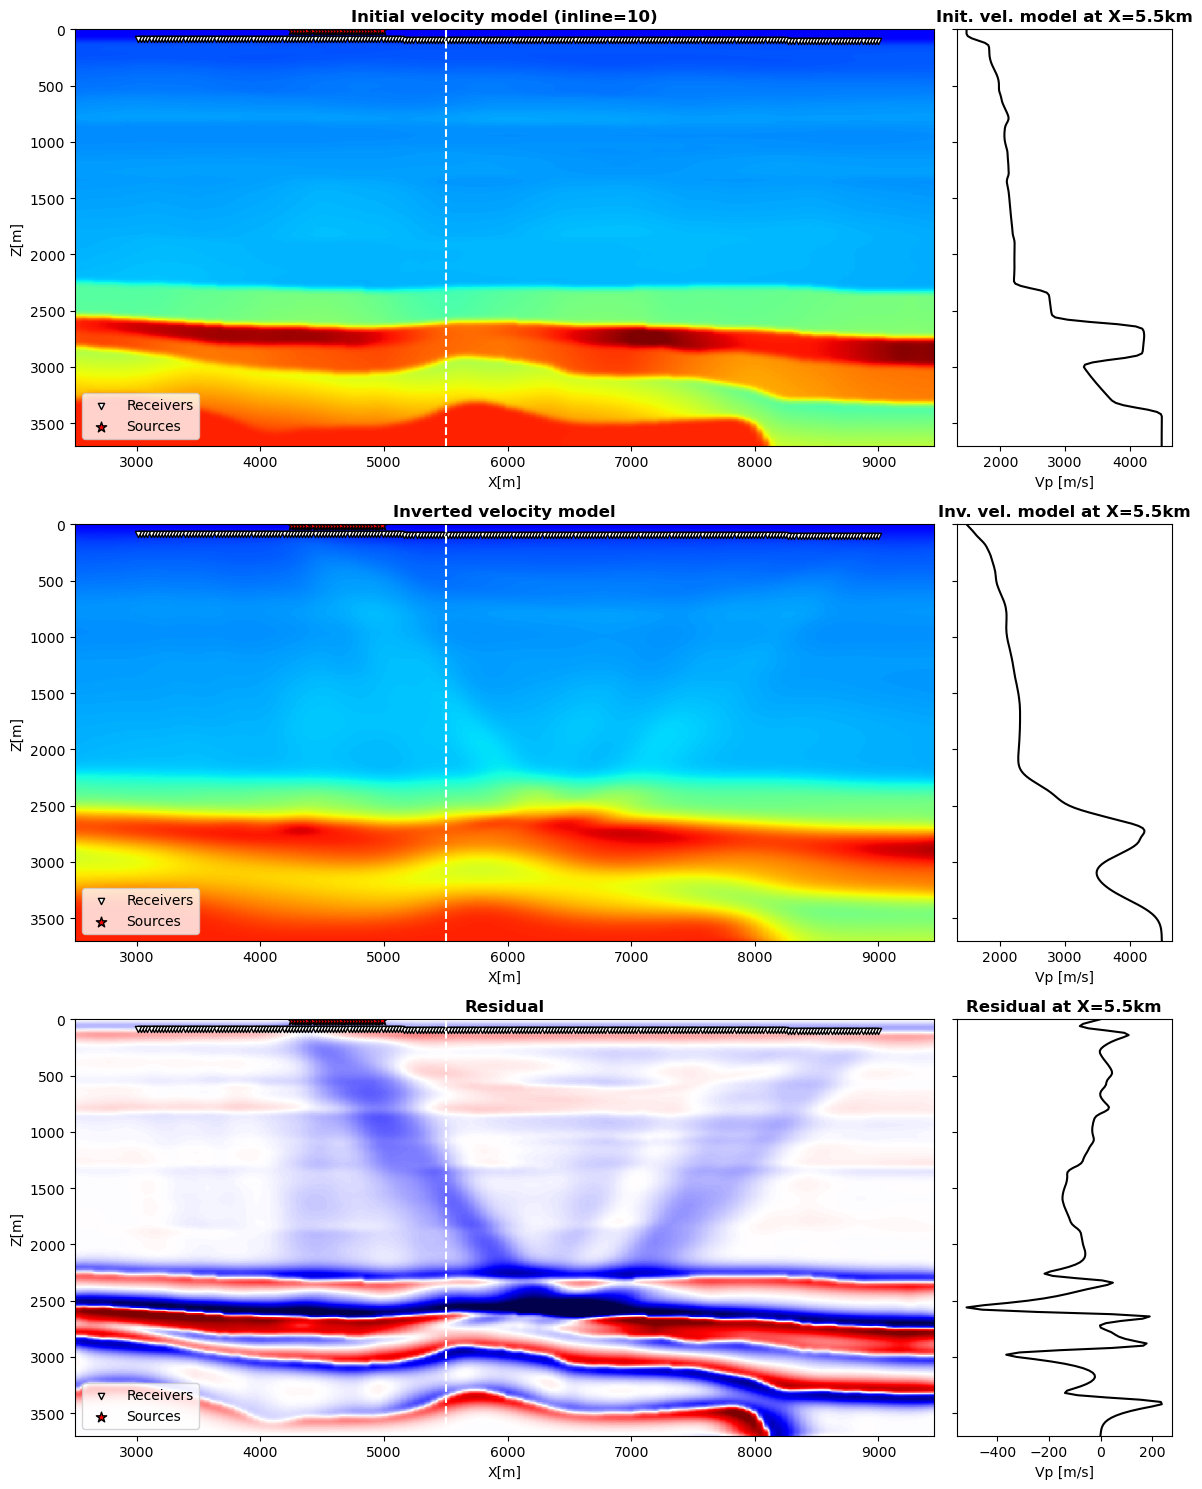

In [93]:
# Display velocity model
fig, axs = plt.subplots(3, 2, figsize=(12, 15), sharey=True, gridspec_kw={'width_ratios': [4, 1]})

vmin=1000; vmax=5000

# Plot migration velocity model
axs[0, 0].imshow(vmod2d.T, extent=(x[0], x[-1], z[-1], z[0]), cmap='jet', vmin=vmin, vmax=vmax)
# Show receivers and sources
axs[0, 0].scatter(sg.recx_local, sg.recz, marker='v', s=20, c='w', edgecolors='k', label='Receivers')
axs[0, 0].scatter(sg.srcx_local, sg.srcz, marker='*', s=60, c='r', edgecolors='k', label='Sources')

# Do a vertical profile
prf = 60
axs[0, 0].axvline(x[prf], color='w', linestyle='--')

axs[0, 0].set_title(f'Initial velocity model (inline={inline})', fontweight='bold')
axs[0, 0].set_xlabel('X[m]')
axs[0, 0].set_ylabel('Z[m]')
axs[0, 0].axis('tight')
axs[0, 0].legend()

# Plot velocity profile at XL=40
axs[0, 1].plot(vmod2d[prf], z, 'k')
axs[0, 1].set_title('Init. vel. model at X=5.5km', fontweight='bold')
axs[0, 1].set_xlabel('Vp [m/s]')

# Plot inverted velocity model
axs[1, 0].imshow(vel_inv.T, extent=(x[0], x[-1], z[-1], z[0]), cmap='jet', vmin=vmin, vmax=vmax)
# Show receivers and sources
axs[1, 0].scatter(sg.recx_local, sg.recz, marker='v', s=20, c='w', edgecolors='k', label='Receivers')
axs[1, 0].scatter(sg.srcx_local, sg.srcz, marker='*', s=60, c='r', edgecolors='k', label='Sources')
# Highlight the crossline
axs[1, 0].axvline(x[prf], color='w', linestyle='--')
axs[1, 0].set_title('Inverted velocity model', fontweight='bold')
axs[1, 0].set_xlabel('X[m]')
axs[1, 0].set_ylabel('Z[m]')
axs[1, 0].axis('tight')
axs[1, 0].legend()

# Plot velocity profile at XL=40
axs[1, 1].plot(vel_inv[prf], z, 'k')
axs[1, 1].set_title('Inv. vel. model at X=5.5km', fontweight='bold')
axs[1, 1].set_xlabel('Vp [m/s]')

# Plot residual velocity
axs[2, 0].imshow(vmod2d.T - vel_inv.T, extent=(x[0], x[-1], z[-1], z[0]), cmap='seismic', vmin=-500, vmax=500)
# Show receivers and sources
axs[2, 0].scatter(sg.recx_local, sg.recz, marker='v', s=20, c='w', edgecolors='k', label='Receivers')
axs[2, 0].scatter(sg.srcx_local, sg.srcz, marker='*', s=60, c='r', edgecolors='k', label='Sources')
# Highlight the crossline
axs[2, 0].axvline(x[prf], color='w', linestyle='--')
axs[2, 0].set_title('Residual', fontweight='bold')
axs[2, 0].set_xlabel('X[m]')
axs[2, 0].set_ylabel('Z[m]')
axs[2, 0].axis('tight')
axs[2, 0].legend()

# Plot velocity profile at XL=40
axs[2, 1].plot(vmod2d[prf] - vel_inv[prf], z, 'k')
axs[2, 1].set_title('Residual at X=5.5km', fontweight='bold')
axs[2, 1].set_xlabel('Vp [m/s]')

plt.tight_layout();
plt.show()

## Nonlinear Least-Squares (TRF)

Let's attempt to improve the inversion by using "least_squares", which allows to bound the solution to a certain range.

In [ ]:
 # Lenght and steps of rays
lmax = 20000
nl = 20000
# Choose angles to shoot rays, considering the size of the vel. model
thetas = np.hstack([np.arange(-70, -0.2, 0.2), np.arange(0.2, 70, 0.2)])

# Create the class RefrTomo
rt = RefrTomo(survey, avasurvey, xint, z, lmax, nl, thetas, 
                 dzout=1., ray_rec_mindistance=5., tolerance_z=5., epsL=1., weightsL=(45, 15),
                 returnJ=True, debug=True)

# v_final, misfit = rt.solve(vel_inv, niter=5, lsqr_args={'damp':4e3, 'atol':1e-06, 'iter_lim':40})

Iteration 1/10
RefrTomo-fun: Computing...
survey_raytrace: 6960 Source-receiver pairs in survey, 342 Source-receiver paired with ray...
match_surveys: 6960 Rays in survey1, 342 Rays in survey2, 342 Matched rays...
tomographic_matrix: 342 rows, 26040 columns
RefrTomo-fun: Misfit 0.0151
RefrTomo-fun: Elapsed time 57.95154809951782 s...
Iteration 2/10
RefrTomo-fun: Computing...
survey_raytrace: 6960 Source-receiver pairs in survey, 362 Source-receiver paired with ray...
match_surveys: 6960 Rays in survey1, 362 Rays in survey2, 362 Matched rays...
tomographic_matrix: 362 rows, 26040 columns
RefrTomo-fun: Misfit 0.0217
RefrTomo-fun: Elapsed time 66.95649647712708 s...
Iteration 3/10
RefrTomo-fun: Computing...
survey_raytrace: 6960 Source-receiver pairs in survey, 329 Source-receiver paired with ray...
match_surveys: 6960 Rays in survey1, 329 Rays in survey2, 329 Matched rays...
tomographic_matrix: 329 rows, 26040 columns
RefrTomo-fun: Misfit 0.0273
RefrTomo-fun: Elapsed time 70.591171503067

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

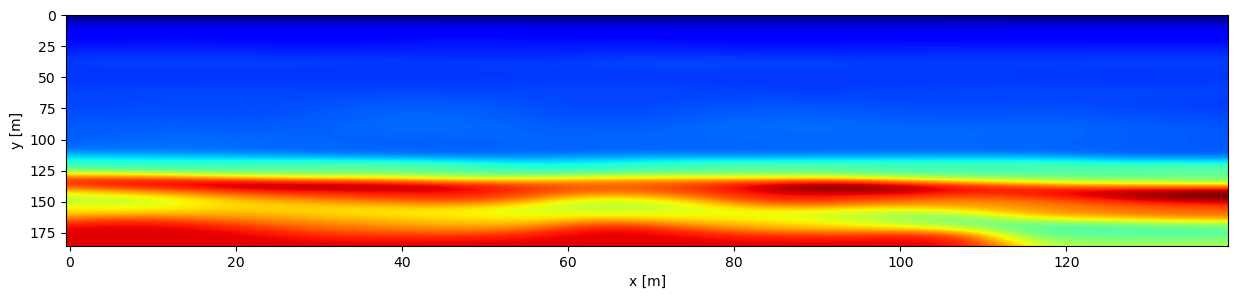

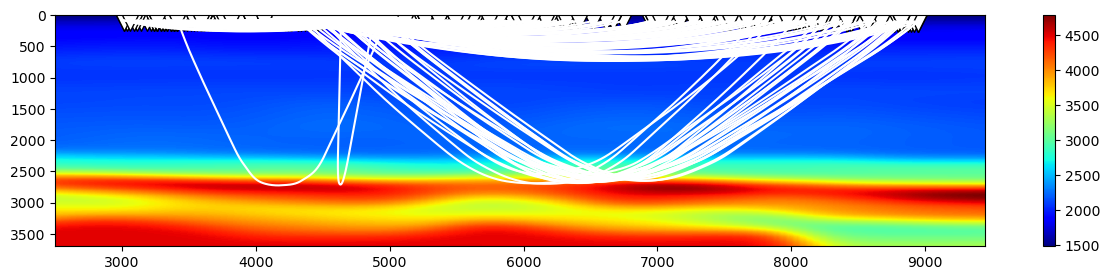

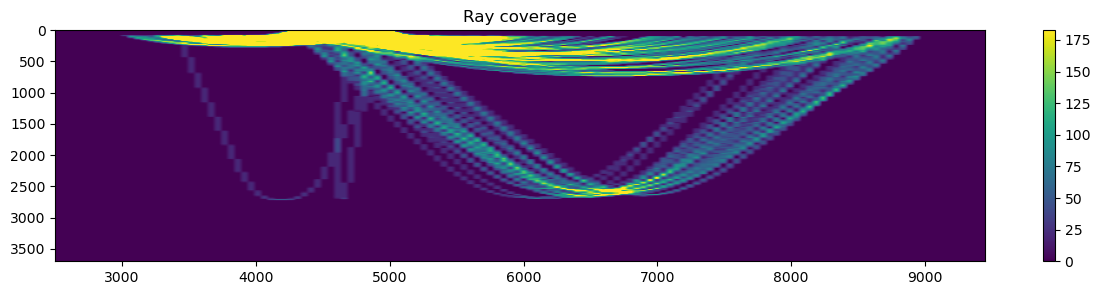

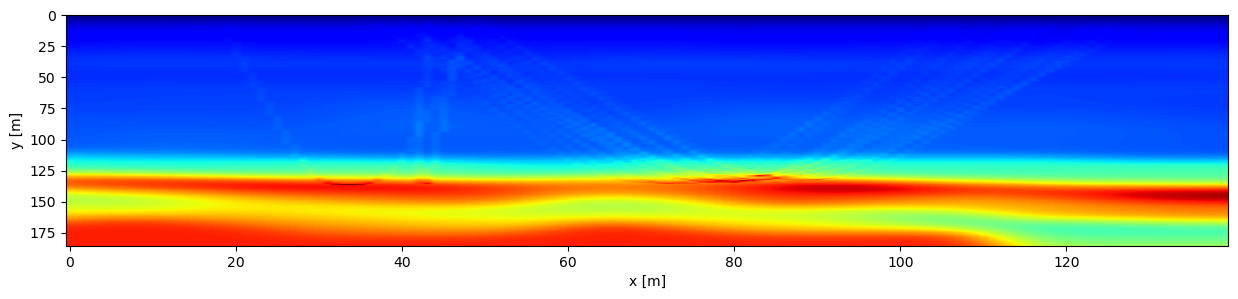

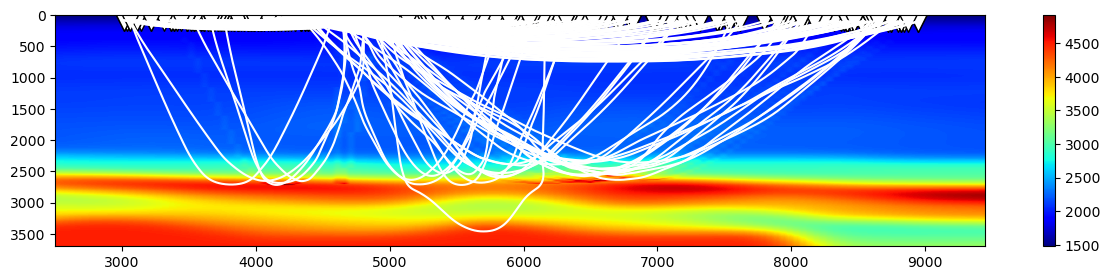

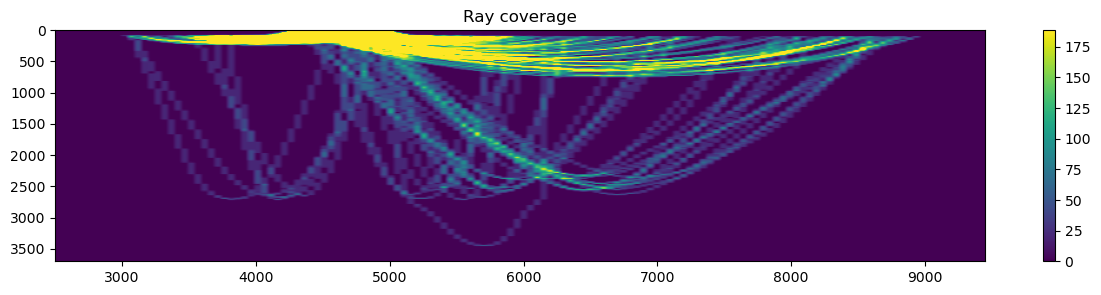

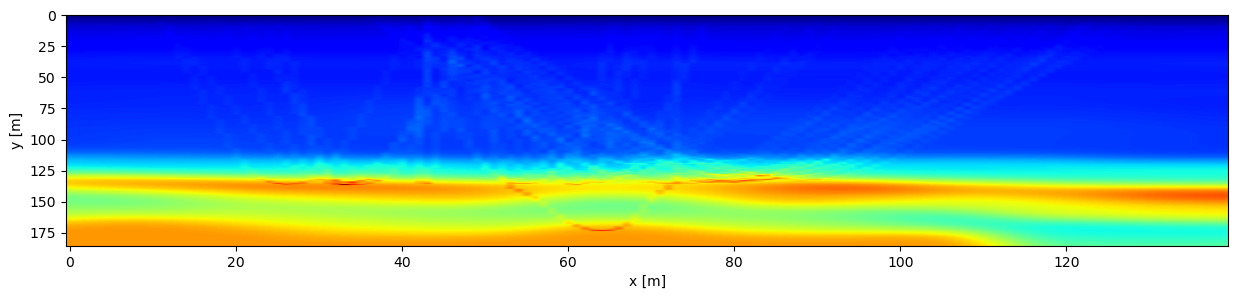

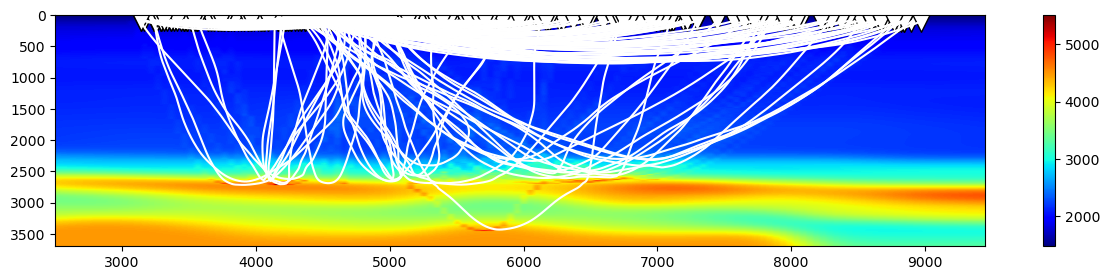

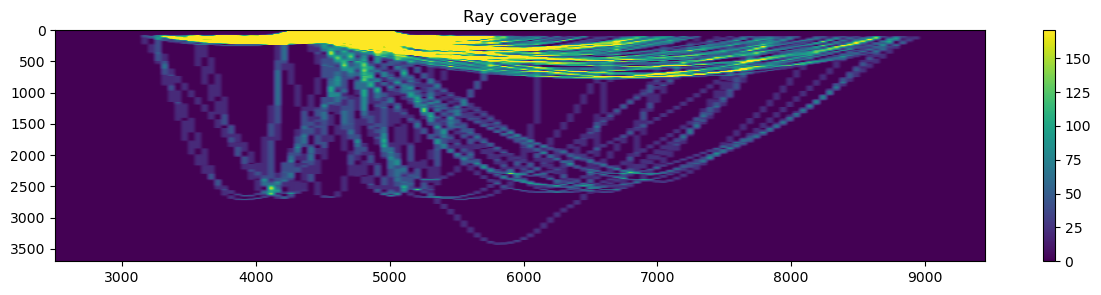

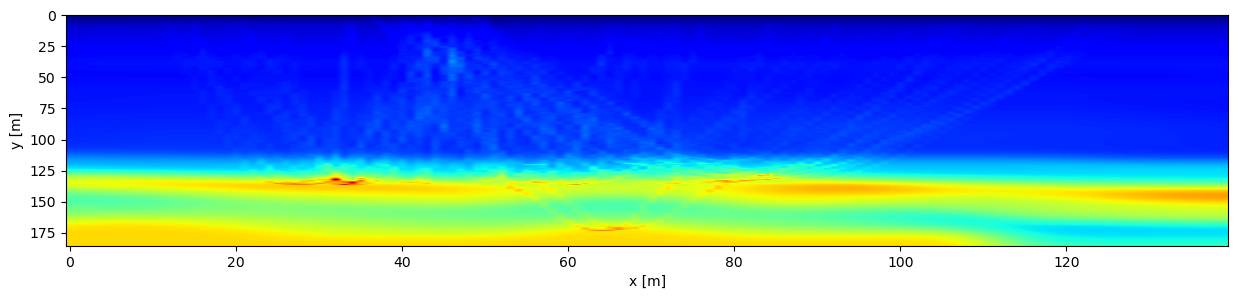

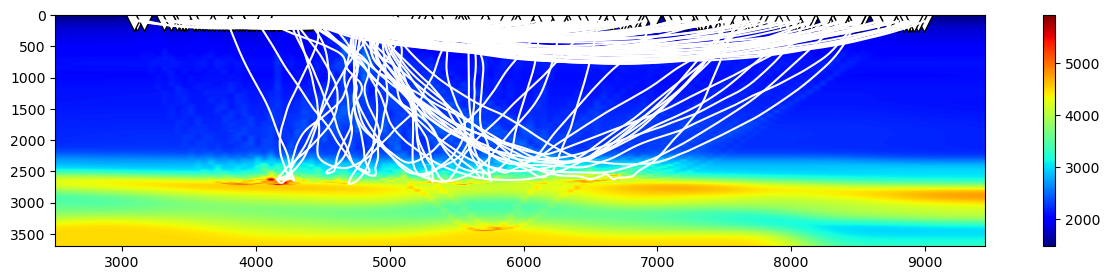

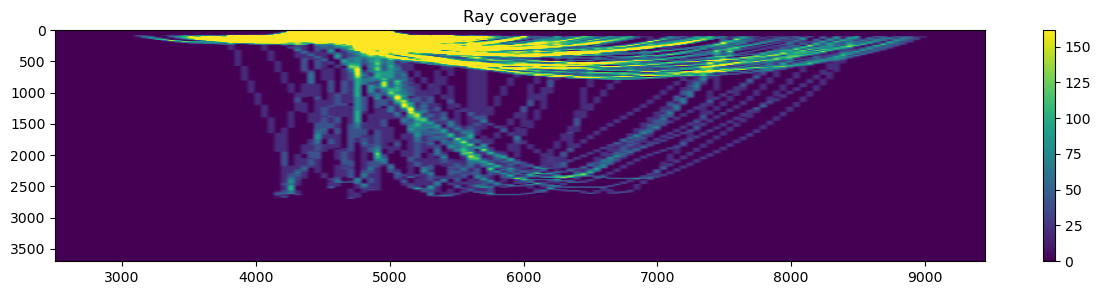

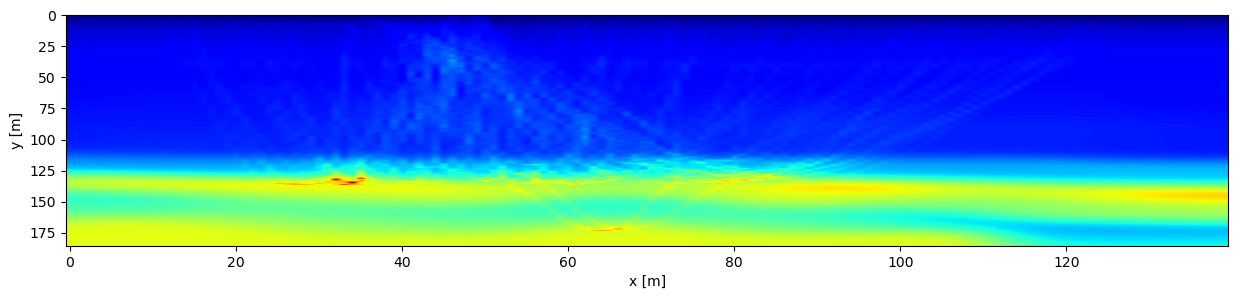

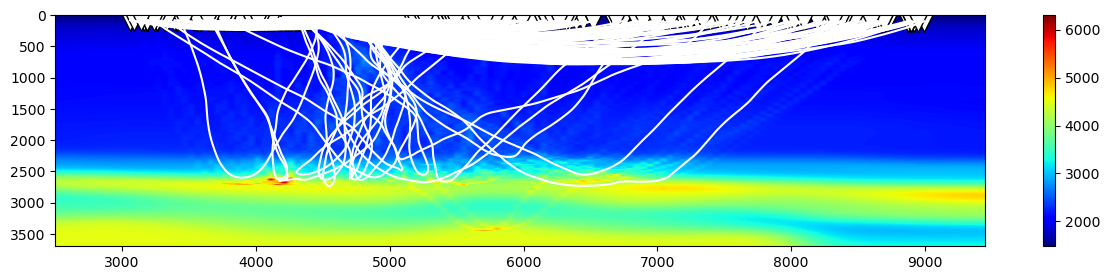

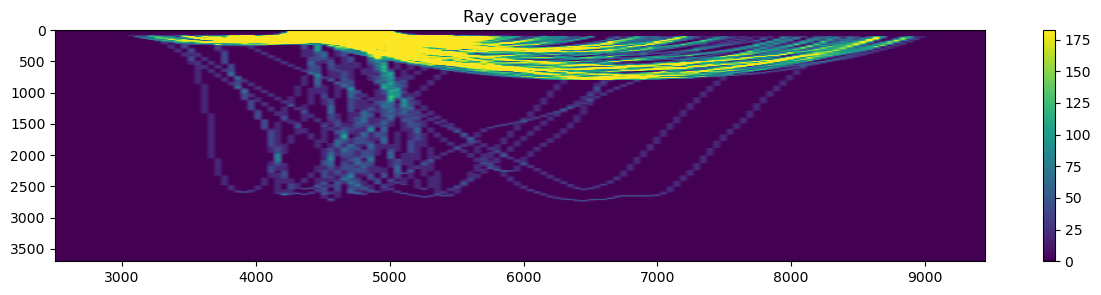

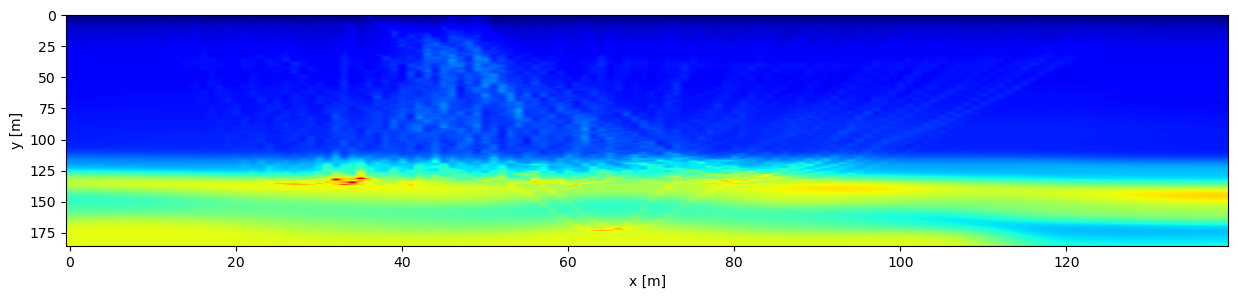

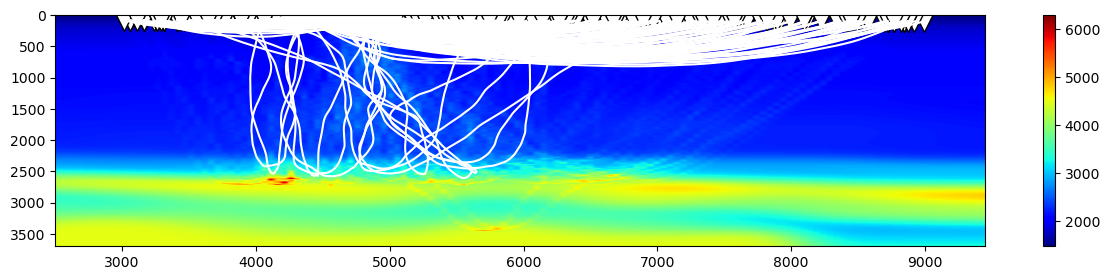

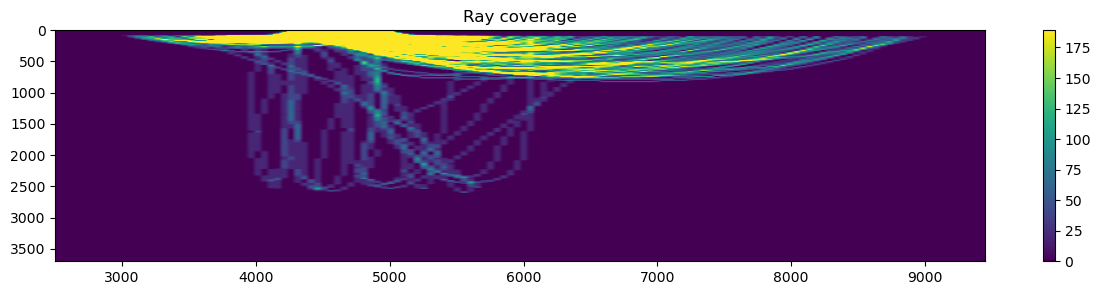

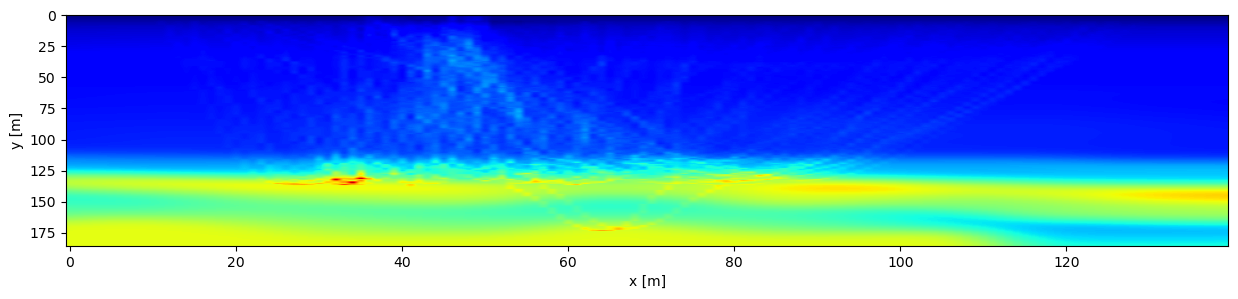

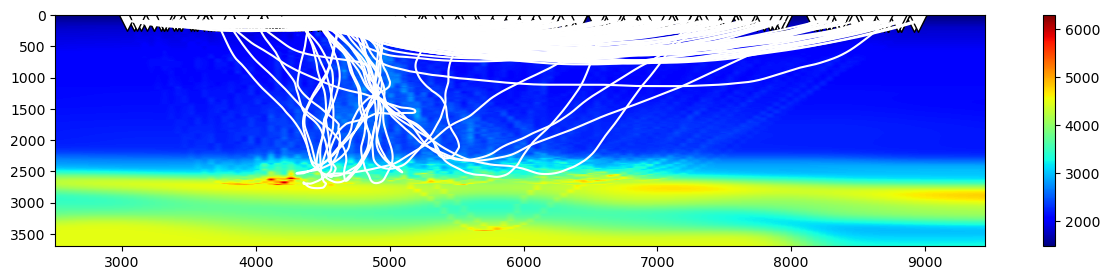

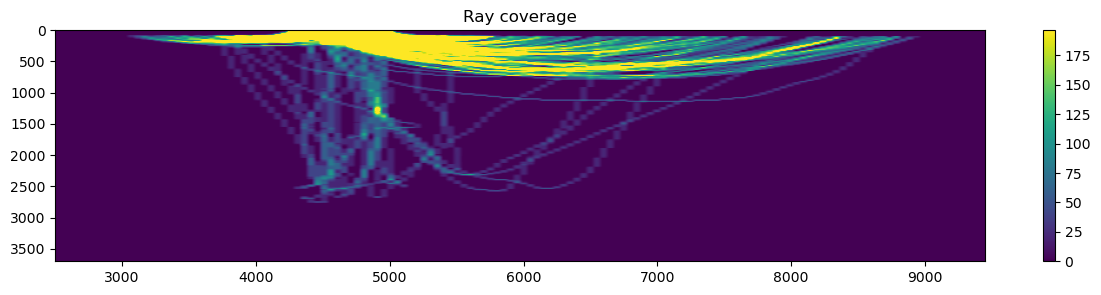

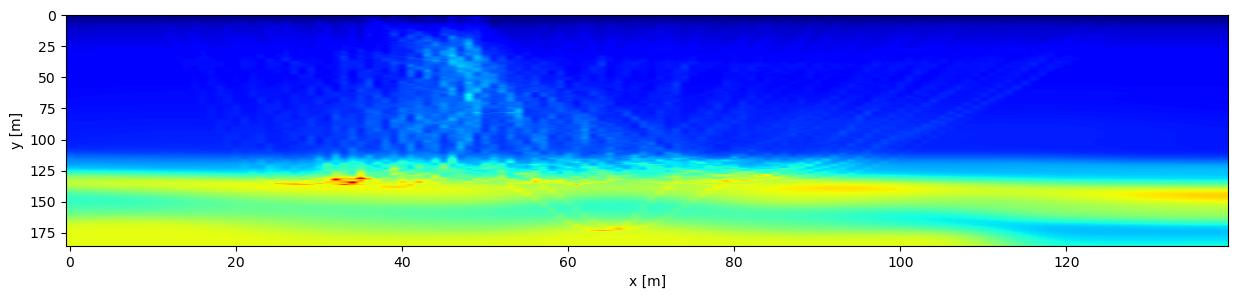

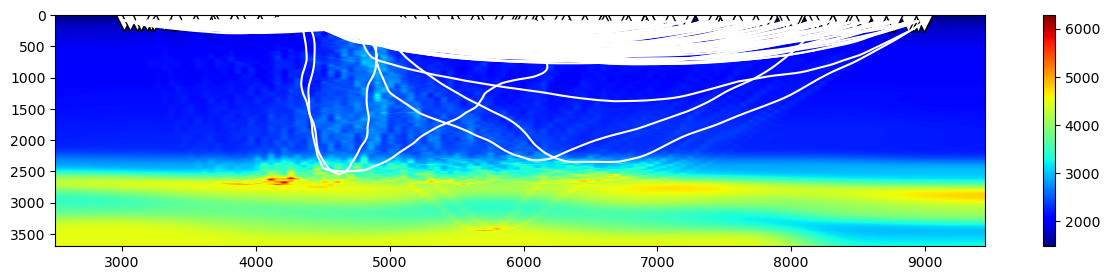

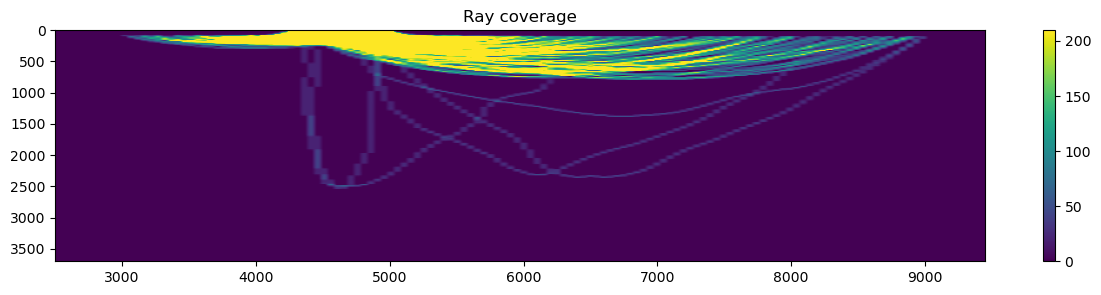

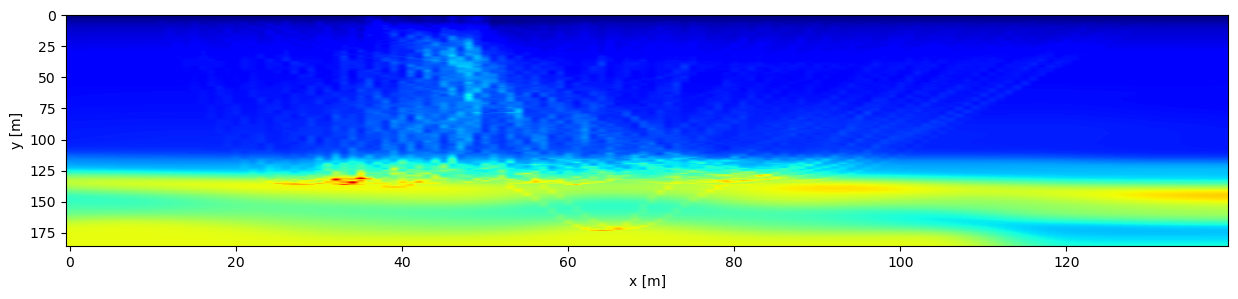

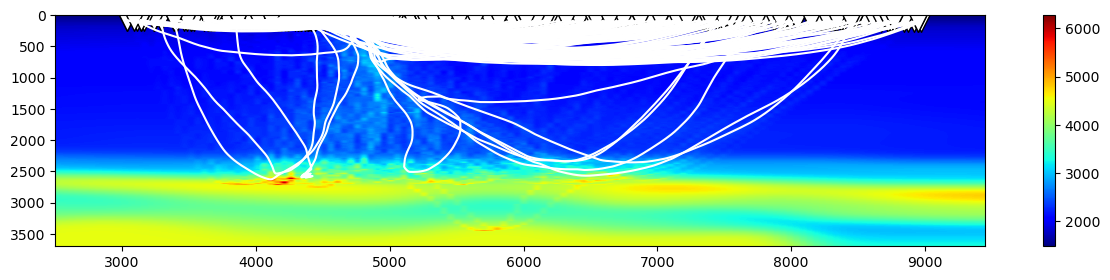

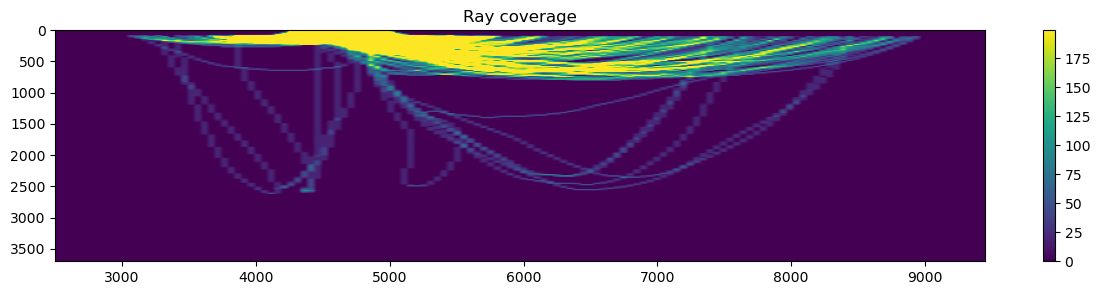

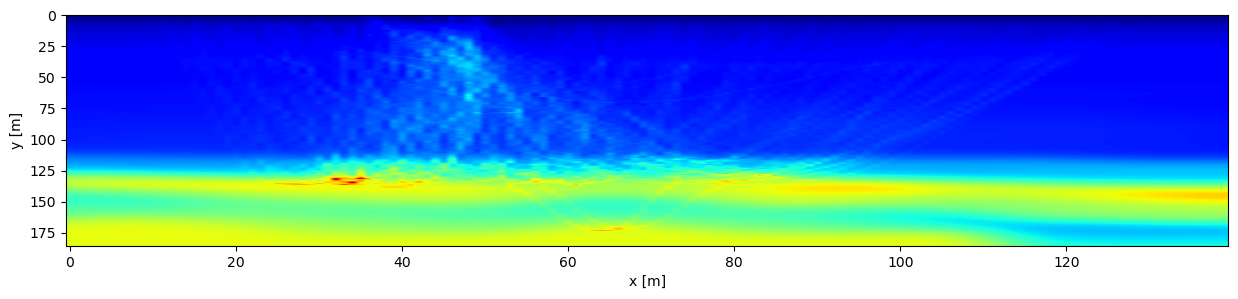

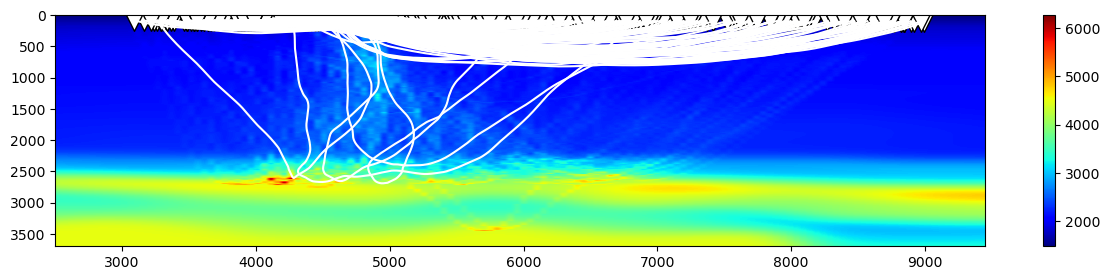

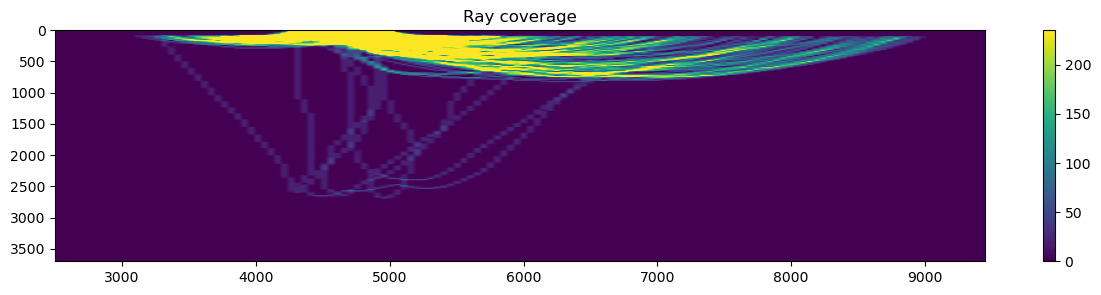

In [9]:
# second version, updating dslow with full dtobs at each step
ngniter = 5

vel_inv = vel_init.copy().ravel()

for iiter in range(ngniter):
    # Invert slowness update (just few iterations to avoid overfitting at each step)
    dvel_inv = least_squares(
        fun=rt.solve, x0=vel_inv, jac='3-point', bounds=(1000, 5000), method='trf',
        ftol=1e-8, xtol=1e-8, gtol=1e-8, x_scale=1.0, loss='linear',
        f_scale=1.0, diff_step=None, tr_solver=None, tr_options={},
        jac_sparsity=None, max_nfev=None, verbose=0, args=(10,2e3), kwargs={})[0]
 
    vel_inv += dvel_inv
    # vel_inv = 1. / (slown_inv.reshape(nx, nz) + 1e-10)